In [80]:
#Importing libraries
import torch
import torchvision
from torchvision import datasets,transforms,models
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import torch.optim as optim
from torchsummary import summary

In [81]:
#Dataset path
data_dir = r'E:\project\dataset'

In [82]:
#transforming using pytorch methods
transformer = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)
database = ImageFolder(data_dir, transform=transformer)

In [83]:
database

Dataset ImageFolder
    Number of datapoints: 390
    Root location: E:\project\dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [84]:
indices = list(range(len(database)))
training_size = int(np.floor(0.77*len(database)))
test_size = int(np.floor(0.12*len(database)))
validation_size = len(database)-training_size-test_size
np.random.shuffle(indices)
print(training_size, validation_size, test_size, len(database))

300 44 46 390


In [85]:
train_indices, validation_indices,test_indices = (
    indices[:training_size],
    indices[training_size:(training_size+validation_size)],
    indices[(training_size+validation_size):]
)
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)
targets_size = len(database.class_to_idx)

In [86]:
#Initializing batch size and creating list of batches in train and test datasets
batch_size = 16
train_loader = torch.utils.data.DataLoader(database, batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(database, batch_size=batch_size,sampler=validation_sampler)
test_loader=torch.utils.data.DataLoader(database, batch_size=batch_size,sampler=test_sampler)

In [125]:
database.classes

['Aloe_Vera',
 'Amla',
 'Ashoka',
 'Ashwagandha',
 'Bael',
 'Cinnamon',
 'Henna',
 'Lavender',
 'Marigold',
 'Neem',
 'Peppermint',
 'Tulsi',
 'Turmeric']

In [88]:
classes = ('Aloe_Vera','Amla','Ashoka','Ashwagandha','Bael','Cinnamon','Henna','Lavender','Marigold','Neem','Peppermint','Tulsi','Turmeric')


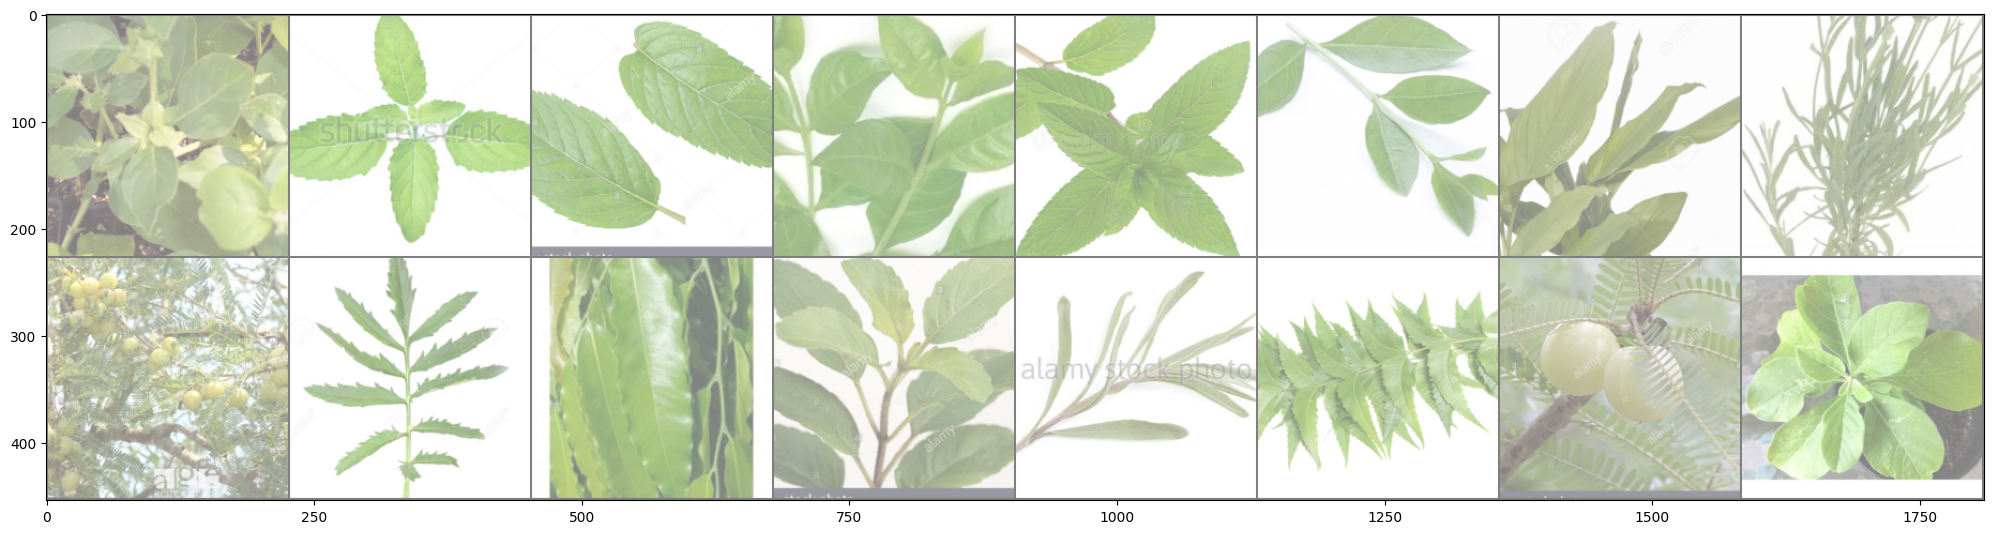

Ashwagandha Tulsi Peppermint Henna Peppermint Henna Turmeric Lavender Amla  Marigold Ashoka Tulsi Lavender Neem  Amla  Ashwagandha


In [89]:
#Showing random images from a single random batch in a grid format
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Original Modelling

In [90]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 13),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

model=CNN()

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [92]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [93]:
#creating optimizer
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

In [94]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    train_accs = np.zeros(epochs)
    validation_accs = np.zeros(epochs)

    for e in range(epochs):

        t0 = datetime.now()
        train_loss = []
        train_acc = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            correct = (predicted == targets).sum().item()
            acc = correct / len(targets)
            train_acc.append(acc)
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)

        validation_loss = []
        validation_acc = []
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            correct = (predicted == targets).sum().item()
            acc = correct / len(targets)
            validation_acc.append(acc)
            loss.backward()
            optimizer.step()

        validation_loss = np.mean(validation_loss)
        validation_acc = np.mean(validation_acc)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss
        train_accs[e] = train_acc
        validation_accs[e] = validation_acc

        dt = datetime.now() - t0

        print(f"Epoch:{e+1}/{epochs}\tTL:{train_loss:.3f}\tVL:{validation_loss:.3f}\tTA:{train_acc:.3f}\tVA:{validation_acc:.3f}\tDuration:{dt}")



    return train_losses, validation_losses, train_accs, validation_accs

In [95]:
train_losses, validation_losses, train_accs, validation_accs = batch_gd(model, criterion, train_loader, validation_loader, 10)

Epoch:1/10	TL:19.782	VL:23.293	TA:0.139	VA:0.104	Duration:0:00:48.600989
Epoch:2/10	TL:23.639	VL:16.188	TA:0.164	VA:0.174	Duration:0:00:47.054592
Epoch:3/10	TL:22.895	VL:18.082	TA:0.150	VA:0.042	Duration:0:00:48.740126
Epoch:4/10	TL:18.878	VL:9.809	TA:0.200	VA:0.285	Duration:0:00:46.617425
Epoch:5/10	TL:15.990	VL:9.732	TA:0.218	VA:0.264	Duration:0:00:47.132483
Epoch:6/10	TL:14.053	VL:12.168	TA:0.206	VA:0.215	Duration:0:00:47.098628
Epoch:7/10	TL:12.585	VL:12.301	TA:0.224	VA:0.285	Duration:0:00:48.181272
Epoch:8/10	TL:8.433	VL:12.941	TA:0.262	VA:0.181	Duration:0:00:48.078911
Epoch:9/10	TL:9.904	VL:2.163	TA:0.205	VA:0.299	Duration:0:00:49.890420
Epoch:10/10	TL:6.083	VL:2.794	TA:0.239	VA:0.417	Duration:0:00:47.445525


Plot the loss


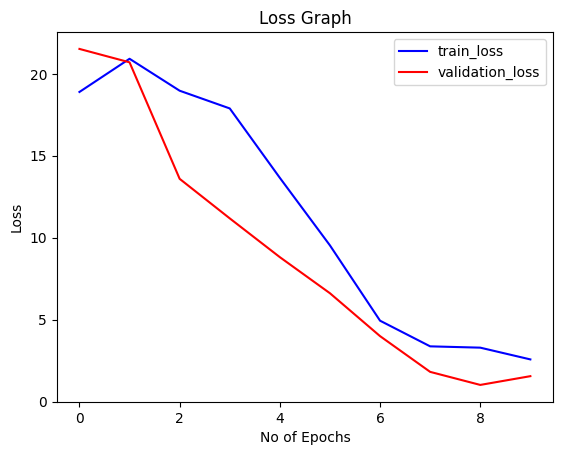

In [111]:
plt.plot(train_losses,'b' , label = 'train_loss')
plt.plot(validation_losses,'r',label='validation_loss')
plt.xlabel('No of Epochs')
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the accuracy graph

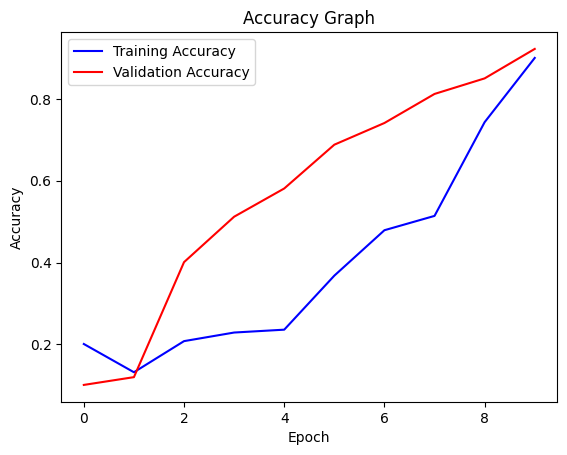

In [127]:
plt.plot(train_accs,'b', label='Training Accuracy')
plt.plot(validation_accs,'r', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

In [128]:
torch.save(model.state_dict(),"plant.pt")

In [129]:
model=CNN()
model.load_state_dict(torch.load("plant.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [130]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.cpu()
    for inputs, targets in loader:
        inputs, targets = inputs.cpu(), targets.cpu()

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [131]:
train_acc = accuracy(train_loader)
validation_acc = accuracy(validation_loader)

In [117]:
print(
    f"Train Accuracy : {train_acc*100} %\nValidation Accuracy : {validation_acc*100} %"
)

Train Accuracy : 94.66666666666667 %
Validation Accuracy : 97.72727272727273 %


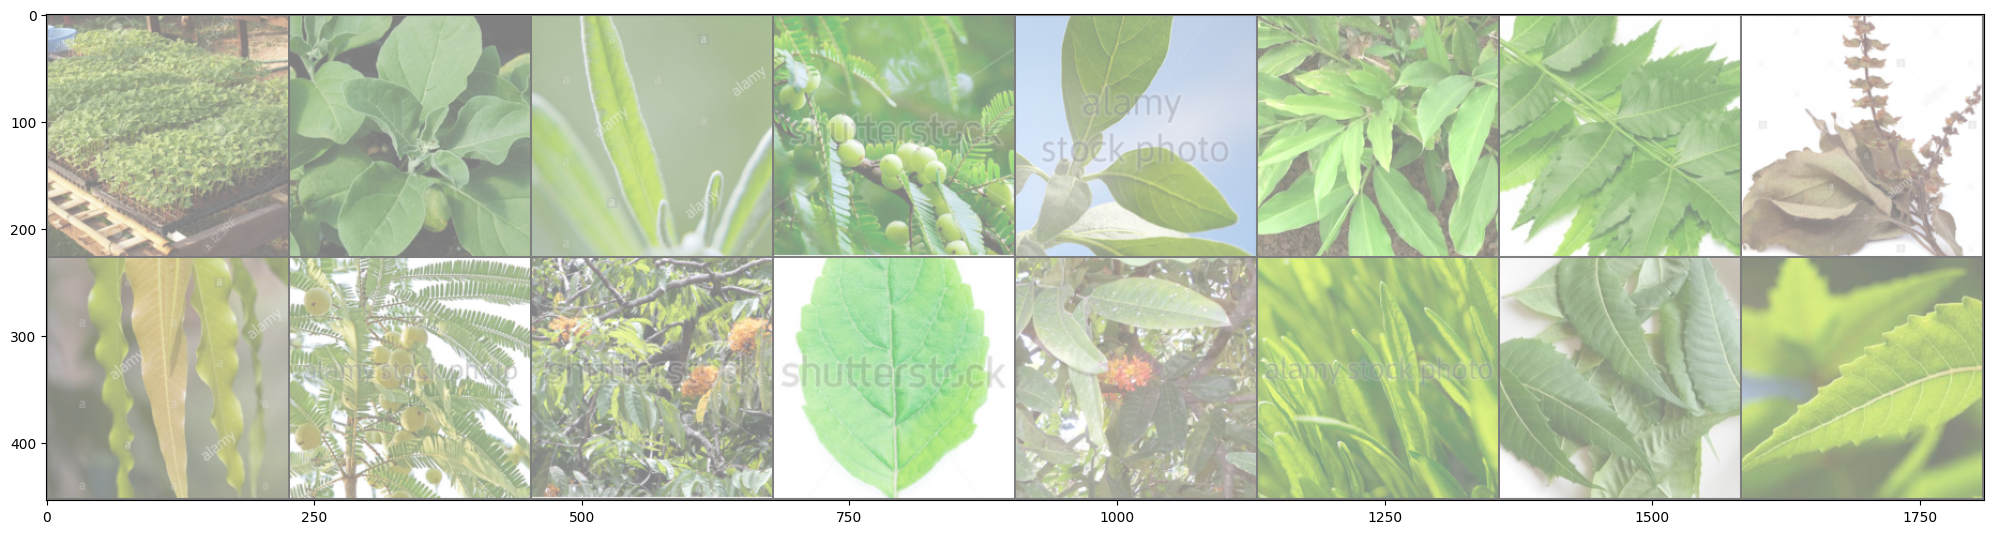

GroundTruth:  Marigold Ashwagandha Lavender Amla  Ashwagandha Turmeric Neem  Tulsi Ashoka Amla  Ashoka Tulsi Ashoka Lavender Neem  Neem 


In [118]:
# Showing sample images from a batch of test dataset
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [119]:
outputs = model(images)

In [120]:
# Sample predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  Marigold Ashwagandha Lavender Amla  Ashwagandha Turmeric Neem  Tulsi Ashoka Amla  Lavender Tulsi Ashoka Lavender Neem  Neem 


In [121]:
#Series and dataframes to store actual and predicted values.
test_results = pd.DataFrame(columns = ['Actual_Image','Predicted_Image'])
Actual_Image= pd.Series(name='Actual_Image',dtype = str)
Predicted_Image= pd.Series(name='Predicted_Image',dtype = str)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        Actual_Image = pd.concat([Actual_Image, pd.Series(labels.tolist(), name='Actual_Image')], ignore_index=True)
        Predicted_Image = pd.concat([Predicted_Image, pd.Series(predicted.tolist(), name='Predicted_Image')], ignore_index=True)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy : {100 * correct / total} %')

Test accuracy : 97.82608695652173 %


In [132]:
# Creating the test results dataframe
test_results = pd.concat([Actual_Image, Predicted_Image], axis=1)

test_results['Actual_Image'] = test_results['Actual_Image'].map(
    {0: 'Aloe_Vera', 1: 'Amla', 2: 'Ashoka', 3: 'Ashwagandha', 4: 'Bael', 5: 'Cinnamon', 6: 'Henna', 7: 'Lavender', 8: 'Marigold', 9: 'Neem', 10: 'Peppermint', 11: 'Tulsi', 12: 'Turmeric'})
test_results['Predicted_Image'] = test_results['Predicted_Image'].map(
    {0: 'Aloe_Vera', 1: 'Amla', 2: 'Ashoka', 3: 'Ashwagandha', 4: 'Bael', 5: 'Cinnamon', 6: 'Henna', 7: 'Lavender', 8: 'Marigold', 9: 'Neem', 10: 'Peppermint', 11: 'Tulsi', 12: 'Turmeric'})
display(test_results)


,Actual_Image,Predicted_Image
0,Neem,Neem
1,Ashwagandha,Ashwagandha
2,Ashoka,Ashoka
3,Ashwagandha,Ashwagandha
4,Amla,Amla
5,Turmeric,Turmeric
6,Marigold,Marigold
7,Turmeric,Turmeric
8,Marigold,Marigold
9,Aloe_Vera,Aloe_Vera


In [133]:
#Printing the metrics like confution matrix of final model prediction and also classification report.
print("Confusion matrix with true and predicted counts of each flower with ID:")
display(pd.crosstab(test_results['Actual_Image'].squeeze(), test_results['Predicted_Image'].squeeze(), rownames=['True'], colnames=['Predicted'], margins=True))

Confusion matrix with true and predicted counts of each flower with ID:


Predicted,Aloe_Vera,Amla,Ashoka,Ashwagandha,Bael,Cinnamon,Henna,Lavender,Marigold,Neem,Peppermint,Tulsi,Turmeric,All
True,,,,,,,,,,,,,,
Aloe_Vera,2,0,0,0,0,0,0,0,0,0,0,0,0,2
Amla,0,6,0,0,0,0,0,0,0,0,0,0,0,6
Ashoka,0,0,4,0,0,0,0,1,0,0,0,0,0,5
Ashwagandha,0,0,0,6,0,0,0,0,0,0,0,0,0,6
Bael,0,0,0,0,1,0,0,0,0,0,0,0,0,1
Cinnamon,0,0,0,0,0,4,0,0,0,0,0,0,0,4
Henna,0,0,0,0,0,0,1,0,0,0,0,0,0,1
Lavender,0,0,0,0,0,0,0,4,0,0,0,0,0,4
Marigold,0,0,0,0,0,0,0,0,5,0,0,0,0,5


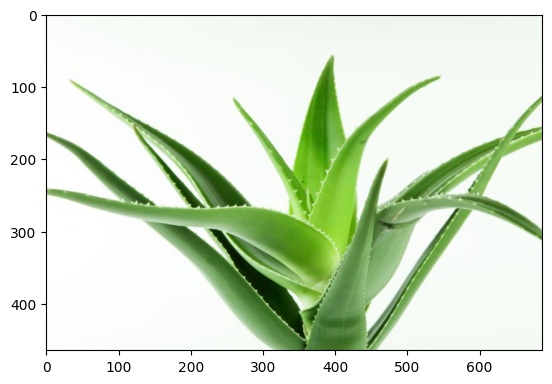

C:\Users\peris\AppData\Local\Temp\ipykernel_7424\3959304837.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(outputs)


[[9.9981125e+01 7.1476711e-07 2.3576374e-06 6.2729133e-09 4.4422569e-07
  4.1376252e-06 4.8997304e-09 7.2163048e-06 6.2572486e-05 1.6540222e-02
  2.5776353e-06 2.2627483e-03 8.4884101e-07]]
Aloe_Vera       :    99.9811 %
Amla            :    0.0 %
Ashoka          :    0.0 %
Ashwagandha     :    0.0 %
Bael            :    0.0 %
Cinnamon        :    0.0 %
Henna           :    0.0 %
Lavender        :    0.0 %
Marigold        :    0.0001 %
Neem            :    0.0165 %
Peppermint      :    0.0 %
Tulsi           :    0.0023 %
Turmeric        :    0.0 %


 Final Predicted image :  Aloe_Vera


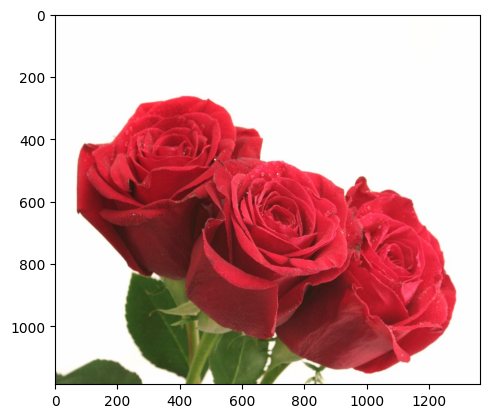

[[ 3.0671294 14.571099  14.430075   3.17555    5.461254   1.5334827
   0.9654282  2.7742057  2.5707595  1.2406483  1.0361371  1.323296
  47.85093  ]]
Aloe_Vera       :    3.0671 %
Amla            :    14.5711 %
Ashoka          :    14.4301 %
Ashwagandha     :    3.1755 %
Bael            :    5.4613 %
Cinnamon        :    1.5335 %
Henna           :    0.9654 %
Lavender        :    2.7742 %
Marigold        :    2.5708 %
Neem            :    1.2406 %
Peppermint      :    1.0361 %
Tulsi           :    1.3233 %
Turmeric        :    47.8509 %


 Final Predicted image :  UNKNOWN PLANT


In [134]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
from tkinter import *

import tkinter as tk

win = tk.Tk()
win.attributes("-fullscreen",True)

font = ('georgia', 22, 'bold')
title = Label(win, text='Herbal Plant Recognition')
title.config(bg='medium spring green', fg='dark goldenrod')
title.config(font=font)
title.config(height=3, width=120)
title.place(x=5, y=5)

font1 = ('times', 12, 'bold')
text = Text(win, height=20, width=80)

myscrollbar=Scrollbar(text)
text.configure(yscrollcommand=myscrollbar.set)
text.place(x=50, y=120)
text.config(font=font1)

font = ('black', 10, 'bold')
Imagetext = Label(win, text='IMAGE DISPLAY')
Imagetext.config(bg='white', fg='dark goldenrod')
Imagetext.config(font=font)
Imagetext.config(height=3, width=20)
Imagetext.place(x=1000, y=530)

font = ('black', 10, 'bold')
Imagetext2 = Label(win, text='**** PREDICTION ****')
Imagetext2.config(bg='white', fg='dark goldenrod')
Imagetext2.config(font=font)
Imagetext2.config(height=3, width=20)
Imagetext2.place(x=1320, y=120)

font1 = ('times',15, 'bold')
predict = Text(win, height=3, width=20)
predict.place(x=1320, y=200)
predict.config(font=font1)


frame = Frame(win, width=500, height=400, bg="lightblue", colormap="new")
frame.pack()
frame.place(x=800, y=120)

from PIL import Image
from torch.autograd import Variable
import matplotlib.image as mpimg

def get_probabilities(image):
  imgplot = plt.imshow(image)
  plt.show()
  image = transformer(image)
  image = image.float()
  image = Variable(image, requires_grad=True)
  image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
  outputs = model(image)
  _, predicted = torch.max(outputs.data, 1)
  sm = torch.nn.Softmax()
  probabilities = sm(outputs) 
  probabilities = probabilities.detach().numpy()
  print(probabilities*100) #Converted to probabilities
  text.delete('1.0', END)
  predict.delete('1.0',END)
  if probabilities.max()*100 >= 65:
      predict.insert(END, (predicted_plant:=classes[predicted.tolist()[0]]).upper())
  else:
      predict.insert(END, predicted_plant:='UNKNOWN PLANT')
  for i,j in enumerate(probabilities[0]):
    str_display = classes[i].ljust(15, ' ')  + ':   ' +  str(round(j*100,4)) + '%\n'
    text.insert(END, str_display)
    print(classes[i].ljust(15, ' ') ,':   ', round(j*100,4),'%')
  print('\n\n Final Predicted image : ', predicted_plant)



def upload_file():
    global img
    for widget in frame.winfo_children():
        widget.destroy()
    f_types = [('Jpg Files', '*.jpg')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    img=Image.open(filename)
    image2= img
    get_probabilities(img)
    img_resized=img.resize((500,400)) # new width & height
    img=ImageTk.PhotoImage(img_resized)
    label = Label(frame, image = img)
    label.pack()


def close():
   win.destroy()

b1 = tk.Button(win,text='Upload \nPhoto', width=20,command = lambda:upload_file())
b1.config(font=('times', 12, 'bold'))
b1.place(x=1000, y=600)

font = ('black', 10, 'bold')
probabilities = Label(win, text='Probabilities of each class')
probabilities.config(bg='white', fg='dark goldenrod')
probabilities.config(font=('times', 12, 'bold'))
probabilities.config(height=3, width=20)
probabilities.place(x=300, y=600)

exitButton = Button(win, text="Exit", command=close)
exitButton.place(x=1200, y=600)
exitButton.config(font=('times', 12, 'bold'))


credit = Label(win, text="Prepared by:\nPeris Raj KC\nPrabhas Gyawali")
credit.config(bg='white', fg='black',font=font, justify='left')
credit.place(relx=1.0, rely=1.0, anchor='se')

win.mainloop()  # Keep the window open